In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.api import VAR
import yfinance as yf
from matplotlib import dates as dt
from numpy import linalg
from scipy.stats import binom

# Sentiment Data

In [3]:
df_sentiment = pd.read_csv("../data/sentiment_daily_data.csv")
df_sentiment.index = pd.DatetimeIndex(df_sentiment["release_date"]).to_period("D")
df_sentiment = df_sentiment.drop('release_date', axis = 1)
df_sentiment

,AAPL_daily,AAPL_diff,AMZN_daily,AMZN_diff,BAC_daily,BAC_diff,CVX_daily,CVX_diff,HD_daily,HD_diff,...,PFE_daily,PFE_diff,PG_daily,PG_diff,TSLA_daily,TSLA_diff,WMT_daily,WMT_diff,XOM_daily,XOM_diff
release_date,,,,,,,,,,,,,,,,,,,,,
2014-01-04,0.9747,-0.9876,0.9870,0.0,1.8862,0.0000,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9595,0.0000
2014-01-05,2.6382,1.6635,0.9870,0.0,0.9956,-0.8906,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9977,0.0382
2014-01-06,2.6382,0.0000,0.9870,0.0,0.9956,0.0000,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,-0.0010
2014-01-07,-0.2695,-2.9077,0.9870,0.0,2.9495,1.9539,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,0.0000
2014-01-08,-0.2695,0.0000,0.9870,0.0,0.9862,-1.9633,1.9993,0.0000,0.9900,0.0,...,0.9881,0.0000,0.9866,0.0,0.8641,0.0,0.9135,0.0000,0.9967,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-09,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,1.9594,0.7939,0.9975,0.0,...,1.9891,0.0000,-0.9581,0.0,20.7979,0.0,0.3612,-0.6384,-0.9922,0.0000
2020-02-10,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,1.9594,0.0000,0.9975,0.0,...,1.9891,0.0000,-0.9581,0.0,20.7979,0.0,0.3612,0.0000,-0.5306,0.4616
2020-02-11,33.1780,0.0000,4.5365,0.0,4.1556,0.0000,0.0732,-1.8862,0.9975,0.0,...,1.5383,-0.4508,-0.9581,0.0,20.7979,0.0,0.3612,0.0000,1.9926,2.5232


# Stock Data

In [4]:
df_prices = pd.read_csv("../data/stock_data_daily_pct_change.csv")
df_prices.index = pd.DatetimeIndex(df_prices["Date"]).to_period("D")
df_prices = df_prices.drop('Date', axis = 1)
df_prices = df_prices.drop("Date.1", axis = 1)

# Drop columns with little amount of data (determined in "Sentiment Analysis.ipynb")
df_prices = df_prices.drop(["LLY", "NVDA", "MA", "UNH", "V"], axis = 1)
df_prices

,AAPL,MSFT,BAC,AMZN,TSLA,XOM,JPM,KO,WMT,CVX,JNJ,HD,PG,MRK,PFE
Date,,,,,,,,,,,,,,,
2011-01-04,0.005219,0.003931,0.003524,0.004288,0.001878,0.004695,0.014473,-0.020699,0.003849,-0.003698,0.008437,-0.018125,0.002779,0.008602,0.017534
2011-01-05,0.008180,-0.003204,0.018258,0.013026,0.005999,-0.002670,0.012229,-0.005950,-0.006573,-0.001747,-0.000631,-0.003172,-0.002310,0.005777,0.006671
2011-01-06,-0.000808,0.029286,-0.004138,-0.008324,0.039135,0.006426,-0.004922,-0.007245,-0.008270,-0.008202,-0.001580,-0.004051,-0.001698,0.013676,0.003865
2011-01-07,0.007161,-0.007634,-0.013158,-0.001991,0.012912,0.005453,-0.018885,-0.001745,0.002224,0.005514,-0.009650,-0.001162,-0.002937,0.007825,0.008801
2011-01-10,0.018833,-0.013287,0.010526,-0.004367,0.007436,-0.006086,-0.005500,0.002225,-0.006472,-0.008554,-0.007029,0.000291,-0.002171,-0.004016,-0.004362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.016319,0.000000,0.006007,0.003638,0.033605,0.005004,-0.000292,-0.001092,-0.010475,0.005431,0.002602,-0.008952,-0.003670,0.001747,0.002294
2019-12-24,0.000951,-0.000191,0.001422,-0.002114,0.014384,-0.003842,0.002770,-0.003642,0.004033,0.000083,-0.003483,0.006660,0.002562,-0.003270,-0.000763
2019-12-26,0.019840,0.008197,0.008518,0.044467,0.013380,0.001571,0.010612,0.005666,0.000084,0.002160,-0.000685,0.000680,0.000000,-0.001093,0.002291


# VAR model of merge


In [5]:
def var_model(df_sentiment: pd.DataFrame, df_prices: pd.DataFrame)-> tuple[VAR, pd.DataFrame]:
    """
    Make a VAR model for a specific stock

    Returns a tuple of the VAR model and a merged dataframe consisting of the prices and
    the sentiment.
    """
    merged_df = pd.merge(df_prices, df_sentiment, left_index= True, right_index = True)
    new_names = {df_sentiment.name: f"{df_prices.name}_sentiment", df_prices.name: f"{df_prices.name}_prices"}
    merged_df = merged_df.rename(new_names, axis=1)
    return VAR(merged_df), merged_df

In [6]:
var_models = []
merged_dfs = []
for ticker in df_prices.columns:
    var, merged_df = var_model(df_sentiment[f"{ticker}_diff"], df_prices[ticker])
    var_models.append(var)
    merged_dfs.append(merged_df)

In [7]:
results = []
for model in var_models:
    result = model.fit(maxlags=35, ic='aic')
    results.append(result)
    print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 22, Dec, 2022
Time:                     01:44:23
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.27623
Nobs:                     1492.00    HQIC:                  -3.39675
Log likelihood:          -1592.73    FPE:                  0.0311691
AIC:                     -3.46833    Det(Omega_mle):       0.0300709
--------------------------------------------------------------------
Results for equation AAPL_prices
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.001052         0.000412            2.556           0.011
L1.AAPL_prices             0.018722         0.026095            0.717           0.473
L1.AAPL_sentiment         -0.00001

# Testing asssumptions

### Assumption 1
The mean of the residuals should be approximately zero:

In [8]:
for result in results:
    sentiment = result.names[0]
    price = result.names[1]
    print(f"{sentiment} resid. mean = ",result.resid[sentiment].mean())
    print(f"{price} resid. mean = ", result.resid[price].mean())

AAPL_prices resid. mean =  -3.7205865436499885e-20
AAPL_sentiment resid. mean =  -1.2191617986232282e-15
MSFT_prices resid. mean =  -7.083357108085284e-19
MSFT_sentiment resid. mean =  -6.012651759957866e-16
BAC_prices resid. mean =  -1.1109636670698698e-18
BAC_sentiment resid. mean =  -2.3700558230823888e-17
AMZN_prices resid. mean =  3.154042683594195e-19
AMZN_sentiment resid. mean =  -7.409402859530457e-16
TSLA_prices resid. mean =  -7.396555793638618e-19
TSLA_sentiment resid. mean =  -1.8935182831714862e-17
XOM_prices resid. mean =  9.899488636240979e-19
XOM_sentiment resid. mean =  1.5631940186722203e-16
JPM_prices resid. mean =  2.0340528432506198e-19
JPM_sentiment resid. mean =  9.467591415857431e-18
KO_prices resid. mean =  -8.157951416751317e-19
KO_sentiment resid. mean =  -3.9158166800406325e-17
WMT_prices resid. mean =  1.3322676295501879e-18
WMT_sentiment resid. mean =  9.592326932761352e-17
CVX_prices resid. mean =  -8.91148916087082e-19
CVX_sentiment resid. mean =  -7.604

### Assumption 2

Covariance matrix of the errors should be positive semi definite:

In [9]:
for result in results:
    cov_matrix = result.resid_corr
    print(linalg.eigvals(cov_matrix))

[1.04662188 0.95337812]
[1.00788712 0.99211288]
[0.92905974 1.07094026]
[0.94624465 1.05375535]
[1.03531543 0.96468457]
[0.95911783 1.04088217]
[1.00378321 0.99621679]
[0.98846532 1.01153468]
[1.09339304 0.90660696]
[0.98085952 1.01914048]
[1.03034024 0.96965976]
[1.07884307 0.92115693]
[1.03233171 0.96766829]
[1.00850229 0.99149771]
[1.06631872 0.93368128]


### Assumption 3

Residuals should have no residual auto correlating:

In [10]:
for result in results:
    print(f"{result.names[0]} and {result.names[1]}:")
    print(result.test_whiteness(result.k_ar+1).summary(), "\n \n")

AAPL_prices and AAPL_sentiment:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 14 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.813          9.488   0.590  4
---------------------------------------- 
 

MSFT_prices and MSFT_sentiment:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 17 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.042          9.488   0.060  4
---------------------------------------- 
 

BAC_prices and BAC_sentiment:
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 7 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.642       

### Assumption 4

Data should be normally distributed:

In [11]:
for result in results:
    print(result.test_whiteness(result.k_ar+1).summary())
    # print(str(result.test_normality()))

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 14 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.813          9.488   0.590  4
----------------------------------------
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 17 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         9.042          9.488   0.060  4
----------------------------------------
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 7 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         2.642          9.488   0.619  4
----------------------------------------
Portmanteau-test for residual autocorrela

Visualizing results in a Matrix:



In [12]:
def normallity_of_residuals(result) -> bool:
    '''This function tests the normality of residuals, given these residuals and returns the p value. Test using significance of alpha = 0.05'''
    p_value = pd.DataFrame(result.test_normality().summary().data).iloc[1,2]
    if p_value < 0.05:
            significant_p = True
    else:
            significant_p = False
    return significant_p

In [13]:
def autocorrelation_of_residuals(result) -> bool:
    '''This function tests the autocOrrelation of residuals, given these residuals and returns the p vavlues'''
    p_value = pd.DataFrame(result.test_whiteness(result.k_ar+1).summary().data).iloc[1,2]
    if p_value < 0.05:
            significant_p = True
    else:
            significant_p = False
    return significant_p

In [14]:
def check_mean_of_residuals(result) -> tuple:
      '''checking if residuals of a VAR results containing the residuals of 2 respective timeseries have mean 0 and returns a tuple containing boolean values
       #  ref: https://en.wikipedia.org/wiki/Vector_autoregression '''
      sentiment = result.names[0]
      price = result.names[1]
      if result.resid[sentiment].mean() < 0.001:
            sentiment_timeseries_residual_mean_of_0 = True
      if result.resid[price].mean() < 0.001:
            price_timeseries_residual_mean_of_0 = True
      if sentiment_timeseries_residual_mean_of_0 and price_timeseries_residual_mean_of_0:
            return True
      else:
            return False


In [15]:
def matrix_is_postivive_and_semidefinite(matrix) -> bool:
    """ checking if covariance matrix is positive and semi-definite. This can be checked by checking of the matrix is symetric and eigenvalues are positive. 
    ref: https://en.wikipedia.org/wiki/Definite_matrix"""
    cov_matrix = result.resid_corr
    cov_matrix = result.resid_corr
    is_symmetric = cov_matrix.shape[0] == cov_matrix.shape[1]
    eigen_values = linalg.eigvals(cov_matrix)
    eigen_values_positive = eigen_values[0]> 0 and eigen_values[1] > 0 
    if is_symmetric and eigen_values_positive:
        covariance_matrix_positive_and_semi_definite = True
    else:
        covariance_matrix_positive_and_semi_definite = False
    return covariance_matrix_positive_and_semi_definite

In [16]:
def Assumption_matrix(List_of_results: list) -> pd.DataFrame:
    '''Creates a dataframe of assumption test results per stock, where true is the value if the assumption passes and False when it does not'''
    dict_of_assumption_test_results_per_stock = {}
    for result in results:
        stock_name = result.names[0]
        dict_of_assumption_test_results = {str(stock_name):{'Mean of residuals = 0':check_mean_of_residuals(result), 'Autocorrelation of residuals = 0': autocorrelation_of_residuals(result), 'Covariance Matrix positive and semidefinite':matrix_is_postivive_and_semidefinite(result), 'normality of residuals':normallity_of_residuals(result)}}
        dict_of_assumption_test_results_per_stock.update(dict_of_assumption_test_results)
    df_of_assumption_test_results = pd.DataFrame(dict_of_assumption_test_results_per_stock)
    return df_of_assumption_test_results

In [1]:
Assumption_matrix(results)

NameError: name 'Assumption_matrix' is not defined

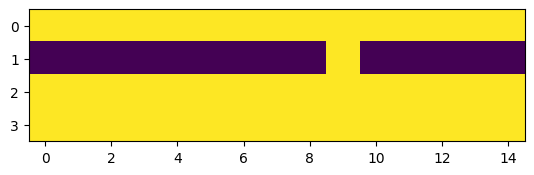

In [18]:
# need to fix colors, right now yellow means assumption passed, while purple means it does not
# assumption tests are the row index while  stock are columns
plt.imshow(Assumption_matrix(results))
plt.show()

In [19]:
for result in results:
    print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 22, Dec, 2022
Time:                     01:44:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.27623
Nobs:                     1492.00    HQIC:                  -3.39675
Log likelihood:          -1592.73    FPE:                  0.0311691
AIC:                     -3.46833    Det(Omega_mle):       0.0300709
--------------------------------------------------------------------
Results for equation AAPL_prices
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.001052         0.000412            2.556           0.011
L1.AAPL_prices             0.018722         0.026095            0.717           0.473
L1.AAPL_sentiment         -0.00001

In [20]:
result.pvalues

,PFE_prices,PFE_sentiment
const,0.159958,8.055060e-01
L1.PFE_prices,0.139075,6.209736e-04
L1.PFE_sentiment,0.942320,1.898089e-22
L2.PFE_prices,0.932604,9.420300e-01
L2.PFE_sentiment,0.143513,6.172192e-09
L3.PFE_prices,0.678151,4.686179e-02
L3.PFE_sentiment,0.399356,5.438807e-11
L4.PFE_prices,0.089754,5.969526e-01
L4.PFE_sentiment,0.295336,2.953311e-08
L5.PFE_prices,0.783415,4.367947e-01


In [21]:
filtered_df_allstocks = pd.DataFrame([])
for result in results:
    p_values_df = result.pvalues
    print(p_values_df)
    significant_p = p_values_df.iloc[:,:] < 0.05
    # print(p_values_df[significant_p])
    p_values_df[significant_p]
    # Create an empty list to store the rows that should be kept
    to_keep = []
    print(result.names)

    # Loop over the rows of the DataFrame
    for index, row in p_values_df[significant_p].iterrows():
        # Check if all elements in the row are null
        if row.isnull().all():
            # If any elements are null, skip this row
            continue
        # If any elements are non-null, append the index to the list of rows to keep
        to_keep.append(index)

    # Use the list of rows to keep to filter the DataFrame
    filtered_df_onestock = p_values_df[significant_p].loc[to_keep]
    print(filtered_df_onestock)

    # filtered_df_allstocks[str(result.names[0][-9:-1])] = filtered_df_onestock



        
        # print(p_values_df[significant_p])

        # for item in p_values_df:
        #     if item < 0.05:
        #         print(item)
            
        #         significant_p[str(item)] = True
        # print(significant_p)
        # significant_p = p_values_df[]

                    AAPL_prices  AAPL_sentiment
const                  0.010581    3.930874e-02
L1.AAPL_prices         0.473084    3.604309e-01
L1.AAPL_sentiment      0.665498    2.641223e-48
L2.AAPL_prices         0.153223    9.945841e-01
L2.AAPL_sentiment      0.272646    7.058407e-38
L3.AAPL_prices         0.547165    7.205481e-01
L3.AAPL_sentiment      0.615424    6.100766e-19
L4.AAPL_prices         0.842126    9.644898e-01
L4.AAPL_sentiment      0.818808    3.338868e-22
L5.AAPL_prices         0.933845    6.731362e-02
L5.AAPL_sentiment      0.104101    6.081045e-07
L6.AAPL_prices         0.840416    3.899104e-01
L6.AAPL_sentiment      0.138106    2.777047e-06
L7.AAPL_prices         0.000724    6.821261e-01
L7.AAPL_sentiment      0.448621    1.253819e-06
L8.AAPL_prices         0.082330    1.072103e-02
L8.AAPL_sentiment      0.648848    8.728137e-08
L9.AAPL_prices         0.213993    5.452172e-01
L9.AAPL_sentiment      0.273540    7.283881e-05
L10.AAPL_prices        0.739975    2.004

In [22]:
dict_of_all_stock_coeff_results = {}
list_of_names = []
dict_of_coeff_results  = {}
for result in results:
    p_values_df = result.pvalues
    significant_p = p_values_df.iloc[:,:] < 0.05
    # print(p_values_df[significant_p])
    # print(p_values_df[significant_p])
    # Create an empty list to store the rows that should be kept
    to_keep = []
    # print(result.names)
    # print(p_values_df)
    # Loop over the rows of the DataFrame
    for index, row in p_values_df[significant_p].iterrows():
        # Check if all elements in the row are null
        if row.isnull().all():
            # If any elements are null, skip this row
            continue
        # If any elements are non-null, append the index to the list of rows to keep
        to_keep.append(index)

    # Use the list of rows to keep to filter the DataFrame
    filtered_df_onestock = p_values_df[significant_p].loc[to_keep]
    # print(p_values_df[significant_p])
    # print(to_keep)
    # print(filtered_df_onestock)
    indices_of_sentiment_variables = []
    # make a list containing the indices of the senitment variables only, since we are only interested in them for our hypothesis.
    index = filtered_df_onestock.iloc[:,0].index
    for item in index:
        try:
            # print(item[-10:])
            if item[-10:] =='_sentiment':
                # print(item)
                indices_of_sentiment_variables.append(item)
        except:
            continue
    # select only the 'price' column (as this is the regressand we are interested in) and select only the rows which are the regressors ('sentiment rows)
    rows_selected = filtered_df_onestock.iloc[:,0].loc[indices_of_sentiment_variables]
    # print(rows_selected)

    # counting the non missing (significant) sentiment coefficients
    try:
        count = rows_selected.isna().value_counts()[False]
    # excepting away the key error in the case where there are no (significant) sentiment coefficients
    except:
        count = 0
    # create a dict of dicts with significant coefficient count and lag order as inner dict and stock ticker symbol as outer dict
    dict_of_all_stock_coeff_results[result.names[1][:-10]] = {'significant coefficient count (alpha = 0.05)' : count,' lag order ': result.k_ar}


In [23]:
# convert dict of dicts to dataframne
df_significant_sentimet_coeffs_VAR = pd.DataFrame.from_dict(dict_of_all_stock_coeff_results, orient='index')
df_significant_sentimet_coeffs_VAR

,significant coefficient count (alpha = 0.05),lag order
AAPL,1,13
MSFT,2,16
BAC,3,6
AMZN,1,9
TSLA,0,4
XOM,1,5
JPM,0,4
KO,0,8
WMT,1,5
CVX,3,10


In [24]:
sum_of_significant_coefficient_counts = df_significant_sentimet_coeffs_VAR.iloc[:,0].sum()
sum_of_lag_orders = df_significant_sentimet_coeffs_VAR.iloc[:,1].sum()
print('sum of significant coeffs: ', sum_of_significant_coefficient_counts)
print('sum of lag order: ', sum_of_lag_orders)

sum of significant coeffs:  14
sum of lag order:  122


#### To find out if this number of significant coefficients significantly differs from the number of significant coefficients we would expect stem from randomness, we compare it with the amount of succeses (where succes means P_value < 0.05) expected in a binomial distribution with p = 0.05.



sum of significant coeffs = n

sum of lag order = n

so k = 14, n = 122, p = 0.05

p = 0.05 (as this is the probability of a significant result by chance, given alpha = 0.05)

if binom with this parameters is more extreme (so found p > 0.05) we reject H0

P(X >= k) where X is Binom (n, p) = 1- P(X <= k-1) = 1 - binom cdf(k-1)


X => k which is the probability that the result is atleast as extreme as our measurement. The complement of this event is X < k.
Since k must be a whole number, so  X < k is equivalent to  X <= k -1

$\textbf{H0}: p = 0.05$

$\textbf{H1}: p \neq 0.05$

In [25]:
prob = 1 - binom.cdf(14-1, 122, 0.05)
print('Found p-value: ', round(prob,4))
print('H0 is rejected in favor of H1')


Found p-value:  0.0032
H0 is rejected in favor of H1


In [35]:
dict_of_all_stock_coeff_results = {}
list_of_names = []
dict_of_coeff_results  = {}
for result in results:
    p_values_df = result.pvalues
    significant_p = p_values_df.iloc[:,:] < 0.05
    # print(p_values_df[significant_p])
    # print(p_values_df[significant_p])
    # Create an empty list to store the rows that should be kept
    to_keep = []
    # print(result.names)
    # print(p_values_df)
    # Loop over the rows of the DataFrame
    for index, row in p_values_df[significant_p].iterrows():
        # Check if all elements in the row are null
        if row.isnull().all():
            # If any elements are null, skip this row
            continue
        # If any elements are non-null, append the index to the list of rows to keep
        to_keep.append(index)

    # Use the list of rows to keep to filter the DataFrame
    filtered_df_onestock = p_values_df[significant_p].loc[to_keep]
    # print(p_values_df[significant_p])
    # print(to_keep)
    # print(filtered_df_onestock)
    indices_of_sentiment_variables = []
    # make a list containing the indices of the senitment variables only, since we are only interested in them for our hypothesis.
    index = filtered_df_onestock.iloc[:,1].index
    for item in index:
        try:
            # print(item[-7:])
            if item[-7:] =='_prices':
                # print(item)
                indices_of_sentiment_variables.append(item)
        except:
            continue
    # select only the 'price' column (as this is the regressand we are interested in) and select only the rows which are the regressors ('sentiment rows)
    rows_selected = filtered_df_onestock.iloc[:,1].loc[indices_of_sentiment_variables]
    # print(rows_selected)

    # counting the non missing (significant) sentiment coefficients
    try:
        count = rows_selected.isna().value_counts()[False]
    # excepting away the key error in the case where there are no (significant) sentiment coefficients
    except:
        count = 0
    # create a dict of dicts with significant coefficient count and lag order as inner dict and stock ticker symbol as outer dict
    dict_of_all_stock_coeff_results[result.names[1][:-10]] = {'significant coefficient count (alpha = 0.05)' : count,' lag order ': result.k_ar}

In [36]:
dict_of_all_stock_coeff_results

{'AAPL': {'significant coefficient count (alpha = 0.05)': 1,
  ' lag order ': 13},
 'MSFT': {'significant coefficient count (alpha = 0.05)': 0,
  ' lag order ': 16},
 'BAC': {'significant coefficient count (alpha = 0.05)': 0, ' lag order ': 6},
 'AMZN': {'significant coefficient count (alpha = 0.05)': 1, ' lag order ': 9},
 'TSLA': {'significant coefficient count (alpha = 0.05)': 1, ' lag order ': 4},
 'XOM': {'significant coefficient count (alpha = 0.05)': 0, ' lag order ': 5},
 'JPM': {'significant coefficient count (alpha = 0.05)': 1, ' lag order ': 4},
 'KO': {'significant coefficient count (alpha = 0.05)': 1, ' lag order ': 8},
 'WMT': {'significant coefficient count (alpha = 0.05)': 0, ' lag order ': 5},
 'CVX': {'significant coefficient count (alpha = 0.05)': 1, ' lag order ': 10},
 'JNJ': {'significant coefficient count (alpha = 0.05)': 3, ' lag order ': 7},
 'HD': {'significant coefficient count (alpha = 0.05)': 1, ' lag order ': 5},
 'PG': {'significant coefficient count (alp

In [38]:
sum_of_significant_coefficient_counts = df_significant_sentimet_coeffs_VAR.iloc[:,0].sum()
sum_of_lag_orders = df_significant_sentimet_coeffs_VAR.iloc[:,1].sum()
print('sum of significant coeffs: ', sum_of_significant_coefficient_counts)
print('sum of lag order: ', sum_of_lag_orders)

sum of significant coeffs:  13
sum of lag order:  122


In [37]:
# convert dict of dicts to dataframne
df_significant_sentimet_coeffs_VAR = pd.DataFrame.from_dict(dict_of_all_stock_coeff_results, orient='index')
df_significant_sentimet_coeffs_VAR

,significant coefficient count (alpha = 0.05),lag order
AAPL,1,13
MSFT,0,16
BAC,0,6
AMZN,1,9
TSLA,1,4
XOM,0,5
JPM,1,4
KO,1,8
WMT,0,5
CVX,1,10


In [62]:
prob = 1 - binom.cdf(sum_of_significant_coefficient_counts, sum_of_lag_orders, 0.05)
print('Found p-value: ', round(prob,4))
print('H0 is rejected in favor of H1')

Found p-value:  0.0032
H0 is rejected in favor of H1


[13, 12, 7, 9, 5, 13]

so k = 2, n = 13, p = 0.05

lag order = n, 

found significant count = k,

p = 0.05 (or 0.01)

if binom with this parameters is more extreme (so found p > 0.05)

P(X >= k) where X is Binom (n, p) = 1- P(X <= k-1) = 1 - binom cdf(k-1)


X => k which is the probability that the result is atleast as extreme as our measurement. The complement of this event is X < k.
Since k must be a whole number, so  X < k is equivalent to  X <= k -1



# for all stocks

Sum of lag orders = n


k = sum of significant lag order

# Under h0, we assume independence between the p values, as h0 assumes p values to be random

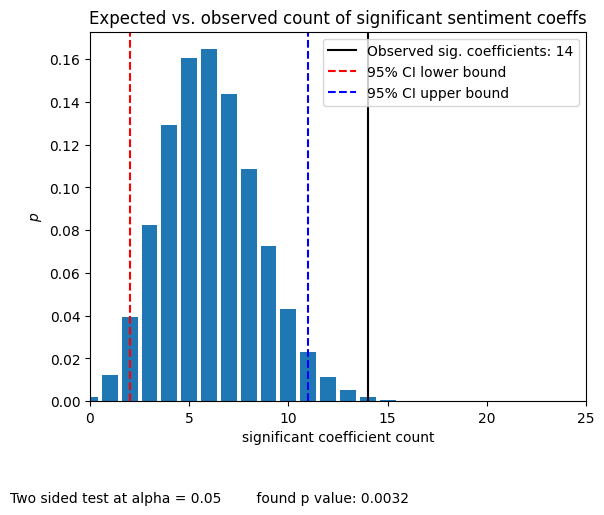

<Figure size 1500x1500 with 0 Axes>

In [65]:
n = 122
p = 0.05
binom_data = [binom.pmf(r, n, p) for r in range(n+1) ]
plt.bar( range(n+1), binom_data)
plt.axvline(14, color = 'black',label = 'Observed sig. coefficients: 14')
plt.title("Expected vs. observed count of significant sentiment coeffs")
CI_95_two_sided = [binom.ppf(0.025, 122, 0.05), binom.ppf(0.975, 122, 0.05)]
plt.axvline(CI_95_two_sided[0], color = 'r',linestyle = 'dashed',label = '95% CI lower bound')
plt.axvline(CI_95_two_sided[1], color = 'b',linestyle = 'dashed',label = '95% CI upper bound')
plt.legend()
plt.xlabel(r'significant coefficient count')
plt.ylabel(r'$p$')
plt.xlim([0,25])
plt.figtext(x=0, y =-0.1, s= f'Two sided test at alpha = 0.05        found p value: {str(round(prob,4))}')
plt.figure(figsize=(15,15))
plt.show()



In [ ]:
binom_data

[0.0019154898067750973,
 0.012299460864555906,
 0.03916407275292797,
 0.08245067947984834,
 0.12910040602765732,
 0.16035629380277436,
 0.1645761962712684,
 0.14354014110877544,
 0.10859944886519182,
 0.07239963257679462,
 0.043058728848304105,
 0.02307453411966536,
 0.01123365476878447,
 0.00500284220472181,
 0.002050036843288267,
 0.0007768560669302903,
 0.0002734328919787528,
 8.973339489086021e-05,
 2.7549726501579893e-05,
 7.936763313474541e-06,
 2.151280582336523e-06,
 5.499514270634734e-07,
 1.328830003191648e-07,
 3.040800922635331e-08,
 6.601738845195132e-09,
 1.362042961745529e-09,
 2.674456827718936e-10,
 5.004831490468193e-11,
 8.937199090121723e-12,
 1.5246764327975472e-12,
 2.487629969301246e-13,
 3.885601989400943e-14,
 5.815621398609984e-15,
 8.347781911880363e-16,
 1.1500814089122982e-16,
 1.52191224036517e-17,
 1.9357655688855256e-18,
 2.368077367342166e-19,
 2.787902717785072e-20,
 3.1603755505256294e-21,
 3.4514627722845636e-22,
 3.6331187076679543e-23,
 3.687752071

In [ ]:
list_of_names

['AAPL',
 'MSFT',
 'BAC',
 'AMZN',
 'TSLA',
 'XOM',
 'JPM',
 'KO',
 'WMT',
 'CVX',
 'JNJ',
 'HD',
 'PG',
 'MRK',
 'PFE']

In [ ]:
# list_of_significant_coeffs = significant_coeffs_allstocks.values.tolist()

# # Create an empty DataFrame with three columns
# df = pd.DataFrame(columns=['col1', 'col2', 'col3'])

# # Iterate over the values in the list in groups of three
# for i in range(0, len(list_of_significant_coeffs), 3):
#     # Extract the current group of three values
#     group = list_of_significant_coeffs[i:i+3]
    
#     # Add the values to a new row in the DataFrame
#     df = df.append({'col1': group[0], 'col2': group[1], 'col3': group[2]}, ignore_index=True)

In [ ]:

dict_of_coeff_results  = {}
for result in results:
    p_values_df = result.pvalues
    significant_p = p_values_df.iloc[:,:] < 0.05
    # print(p_values_df[significant_p])
    p_values_df[significant_p]
    # Create an empty list to store the rows that should be kept
    to_keep = []
    # print(result.names)

    # Loop over the rows of the DataFrame
    for index, row in p_values_df[significant_p].iterrows():
        # Check if all elements in the row are null
        if row.isnull().all():
            # If any elements are null, skip this row
            continue
        # If any elements are non-null, append the index to the list of rows to keep
        to_keep.append(index)

    # Use the list of rows to keep to filter the DataFrame
    filtered_df_onestock = p_values_df[significant_p].loc[to_keep]
    significant_counts = pd.DataFrame([])
    label = ['Price', "Sentiment"]
    for col,label in zip(filtered_df_onestock.columns, label):
        print(col)

        try:
            missing = filtered_df_onestock[col][2:].isna().value_counts()[True]
        except:
            continue
        count_of_significant_coeffs = len(filtered_df_onestock[col][2:])-missing
        dict_of_coeff_results[label] = count_of_significant_coeffs
        # print(result.k_ar)
        # print(filtered_df_allstocks[col])
    dict_of_coeff_results['lag order ' + result.names[0][:-7]] = result.k_ar

        # print(non_missing)
        # print(filtered_df_onestock[non_missing].value_counts().sum())
significant_coeffs_allstocks = pd.DataFrame(dict_of_coeff_results, index = [0])
    # filtered_df_allstocks[str(result.names[0][-9:-1])] = filtered_df_onestock


        
        # print(p_values_df[significant_p])

        # for item in p_values_df:
        #     if item < 0.05:
        #         print(item)
            
        #         significant_p[str(item)] = True
        # print(significant_p)
        # significant_p = p_values_df[]

AAPL_prices
AAPL_sentiment
MSFT_prices
MSFT_sentiment
BAC_prices
BAC_sentiment
AMZN_prices
AMZN_sentiment
TSLA_prices
TSLA_sentiment
XOM_prices
XOM_sentiment
JPM_prices
JPM_sentiment
KO_prices
KO_sentiment
WMT_prices
WMT_sentiment
CVX_prices
CVX_sentiment
JNJ_prices
JNJ_sentiment
HD_prices
HD_sentiment
PG_prices
PG_sentiment
MRK_prices
MRK_sentiment
PFE_prices
PFE_sentiment


In [ ]:
significant_coeffs_allstocks


,Price,Sentiment,lag order AAPL,lag order MSFT,lag order BAC,lag order AMZN,lag order TSLA,lag order XOM,lag order JPM,lag order KO,lag order WMT,lag order CVX,lag order JNJ,lag order HD,lag order PG,lag order MRK,lag order PFE
0,2,16,13,16,6,9,4,5,4,8,5,10,7,5,8,6,16


In [ ]:
filtered_df

NameError: name 'filtered_df' is not defined

# Forecasting

In [ ]:
def forecast(results, merged_df):

    # get ticker name by removing "_prices"
    ticker = results.names[0][:-7]

    # last date in train set: 2019-12-30
    # downloading testset
    test_prices = pd.DataFrame(yf.Ticker(ticker).history(start = '2019-12-30', end = '2020-1-20')['Close'])
    forecast_df = pd.DataFrame(results.forecast(np.array(merged_df), 14))
    forecast_df.columns = ['price', 'sentiment']

    # recall AAPL stock prive is percent change, and APPL setiment is differences
    # undoing the differencing of APPL_sentiment by taking the cumsum
    initial_value = test_prices.iloc[0,:]
    forecast_df["sentiment"].cumsum(axis = 0)
    forecasted_prices = forecast_df.assign(price=forecast_df.price.pct_change(-1)+initial_value[0])
    forecasted_prices['price'].index = test_prices.index

    return forecasted_prices["price"], test_prices

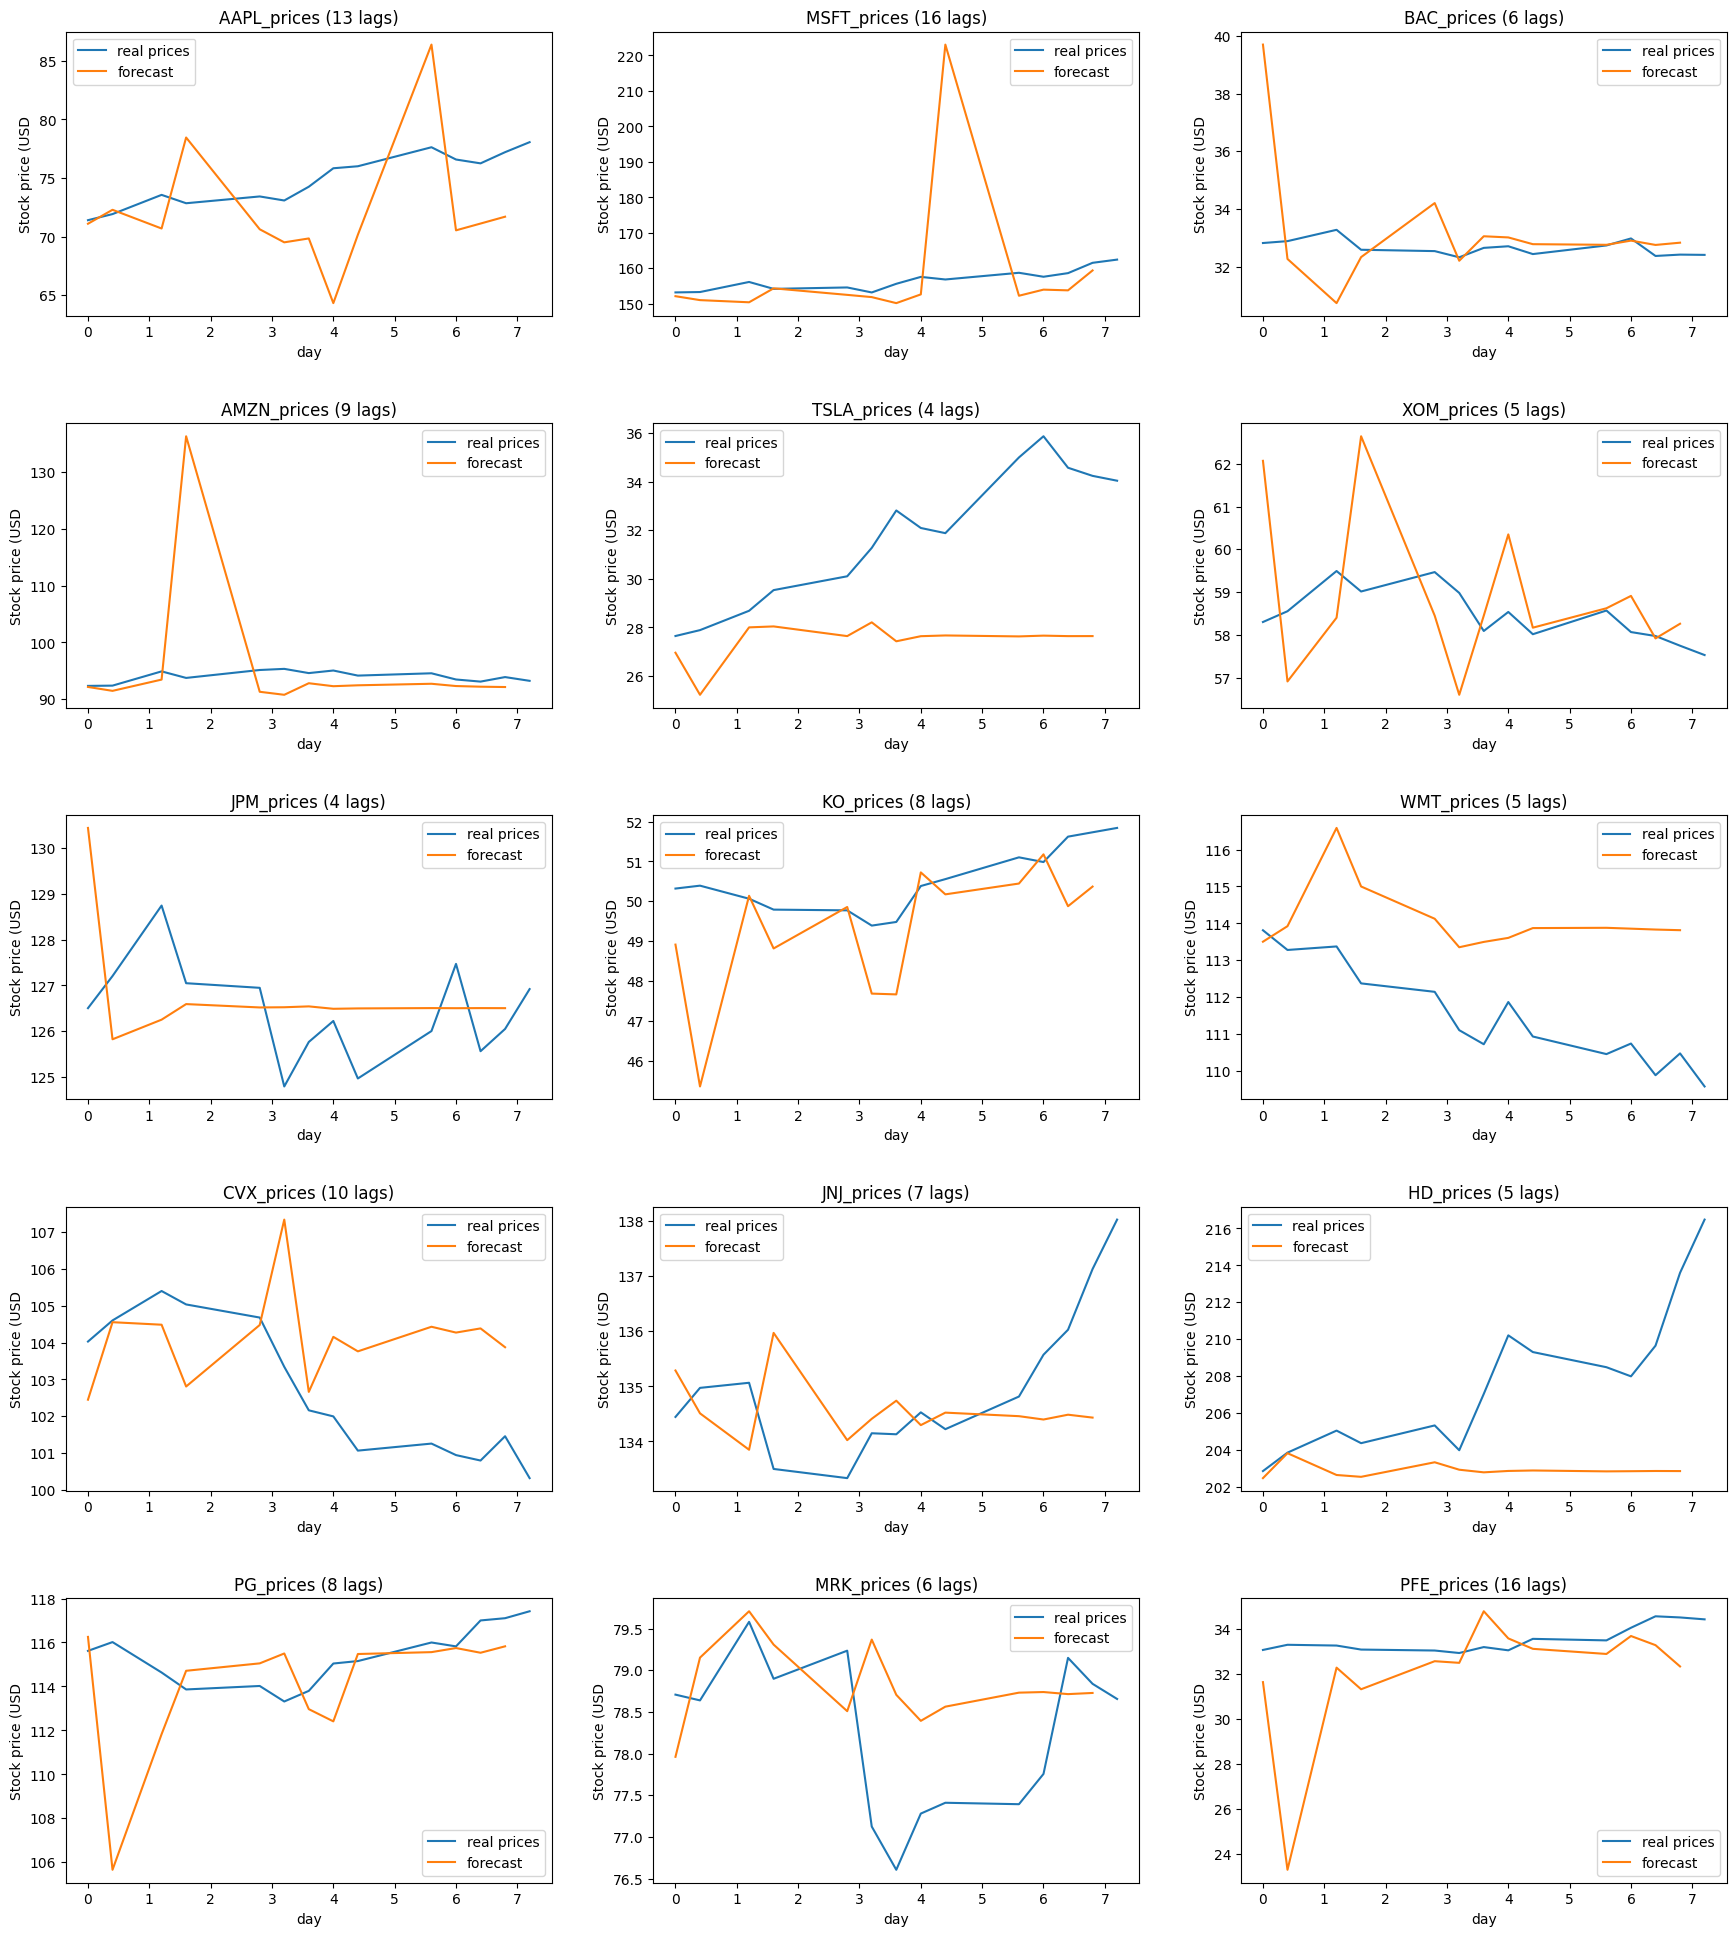

In [ ]:
fig = plt.figure(figsize = (18, 20))
i = 0
for result, merged_df in zip(results, merged_dfs):
    i+=1
    forecasted, real_prices = forecast(result, merged_df)
    plt.subplot(5, 3, i)
    plt.title(f"{result.names[0]} ({result.k_ar} lags)" )
    plt.xlabel('day')
    plt.ylabel('Stock price (USD')
    days = dt.date2num(real_prices.index)
    days = [(t-days[0])/2.5 for t in days]
    plt.plot(days, real_prices["Close"], label='real prices')
    plt.plot(days, forecasted, label='forecast')
    plt.legend()
fig.tight_layout(pad = 3)
plt.show()

In [ ]:
lags = [result.k_ar for result in results]
np.mean(lags)

8.133333333333333

# Using sliding windows for forecast

In [ ]:
def sliding_windows(df, window_size) -> list:
    # Create sliding windows of timeseries for each variable in the dataframe
    # create sliding windows of timeseries per stock:
    list_of_windows_per_variable = []
    for variable in df.columns:
        variable_timeseries = df[str(variable)]
        # Define the window size

        # Initialize the list of windows
        windows = []

        # Iterate over the time series
        for i in np.arange(len(variable_timeseries.index) - window_size + 1, step = window_size):
            # Take the last `window_size` elements of the time series
            # windows are non overlapping, i.e. the first window is from index 0-20, the next from 20-40 etc. 
            # instead of first window being index 0-20, second window being 1-21, etc.
            current_window = variable_timeseries[i : i+window_size]
            window_index = variable_timeseries.index[i : i+window_size]
            # Add the current window to the list of windows
            windows.append(pd.DataFrame(current_window, index = window_index))
        list_of_windows_per_variable.append(windows)
    return list_of_windows_per_variable

In [ ]:
# Sliding windows for AAPL
windows = sliding_windows(merged_dfs[6], window_size = 80)
windows_prices = windows[0]
windows_sentiment = windows[1]


In [ ]:
def VAR_model_windows(windows):
    """Return a tuple containing a list of the VAR models of all windows and a list of
    merged prices/sentiment dataframes."""

    merged_windows = []
    VAR_models = []
    for window_prices, window_sentiments in zip(windows[0], windows[1]):
        merged_window = pd.merge(window_prices, window_sentiments, left_index= True, right_index = True)
        merged_windows.append(merged_window)
        VAR_models.append(VAR(merged_window))

    return VAR_models, merged_windows

In [ ]:
var_models_windows, merged_windows = VAR_model_windows(windows)

window_results = []
for model in var_models_windows:
    result = model.fit(14)
    window_results.append(result)
    print(result.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Dec, 2022
Time:                     09:54:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -6.99100
Nobs:                     66.0000    HQIC:                  -8.15489
Log likelihood:           164.903    FPE:                0.000152720
AIC:                     -8.91525    Det(Omega_mle):     7.37118e-05
--------------------------------------------------------------------
Results for equation JPM_prices
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -0.000056         0.001678           -0.033           0.973
L1.JPM_prices             0.304583         0.161137            1.890           0.059
L1.JPM_sentiment          0.001256     

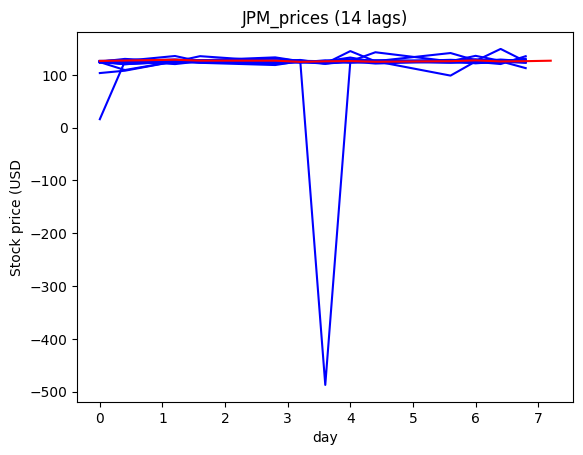

In [ ]:

forecasted_prices = []
for result, merged_df in zip(window_results, merged_windows):
    forecasted, real_prices = forecast(result, merged_df)
    forecasted_prices.append(forecasted)
    days = dt.date2num(real_prices.index)
    days = [(t-days[0])/2.5 for t in days]
    plt.plot(days, forecasted, label='forecast', color="blue")

plt.plot(days, real_prices["Close"], label='real prices', color = "red")
plt.title(f"{result.names[0]} ({result.k_ar} lags)" )
plt.xlabel('day')
plt.ylabel('Stock price (USD')
plt.show()

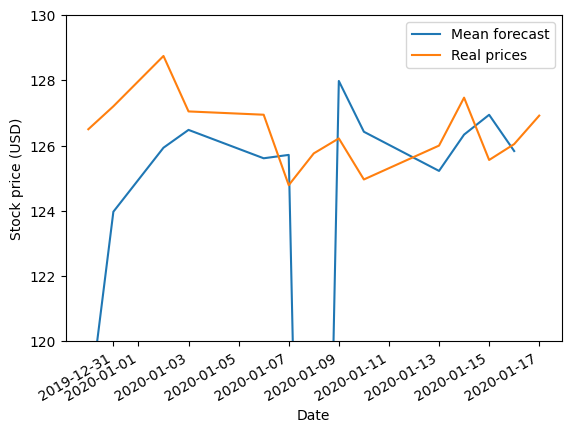

In [ ]:
df = pd.concat(forecasted_prices, axis=1).agg(['mean','std'], axis=1)
df["mean"].plot(label = "Mean forecast")
real_prices["Close"].plot(label = "Real prices")
plt.legend()
plt.ylabel("Stock price (USD)")
plt.xlabel("Date")
plt.ylim(120, 130)
plt.show()